In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns
import scipy.optimize as sco

%matplotlib notebook
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import matplotlib.font_manager as fm
mpl.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max.colwidth',10)
pd.options.display.max_columns = 100

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1) 코스피200(상위10개, 하위10개) 종목으로 최적 위험 포트폴리오 구성 

###  데이터셋 구성
- weekly return

In [3]:
# 260주, 217개 종목
w_return = pd.read_csv('Week_Return.csv',encoding='cp949')
w_return.set_index('Unnamed: 0',inplace=True)
w_return.index.names = ['week']

w_return = w_return.drop(columns=['Date','Week'],axis=1)

# 2015 - 2019 / 상위10개,하위10개
w_return = pd.concat([w_return.iloc[52:312,0:10],w_return.iloc[52:312,-10:217]],axis=1)
w_return.shape

# 종목들만 모은 ticker
ticker = list(w_return.columns)

w_return.index

(260, 20)

Index(['15Y_week1', '15Y_week2', '15Y_week3', '15Y_week4', '15Y_week5',
       '15Y_week6', '15Y_week7', '15Y_week8', '15Y_week9', '15Y_week10',
       ...
       '19Y_week43', '19Y_week44', '19Y_week45', '19Y_week46', '19Y_week47',
       '19Y_week48', '19Y_week49', '19Y_week50', '19Y_week51', '19Y_week52'],
      dtype='object', name='week', length=260)

- 시가총액

In [4]:
# 시가총액  
mkt_cap = pd.read_csv('Mkt_Cap.csv',encoding='cp949')
mkt_cap.set_index('Unnamed: 0',inplace=True)
mkt_cap.index.names = ['week']

mkt_cap = mkt_cap.drop(columns=['Date','Week'],axis=1)

# 2015 - 2019 / 상위10개,하위10개
mkt_cap = pd.concat([w_return.iloc[0:312,0:10],w_return.iloc[0:312,-10:217]],axis=1)
mkt_cap.shape

(260, 20)

- weekly price 

In [8]:
w_price = pd.read_csv('Week_Price.csv',encoding='cp949')
w_price.set_index('Unnamed: 0',inplace=True)
w_price.index.names = ['week']

w_price = w_price.drop(columns=['Date','Week'],axis=1)

# 2015 - 2019 / 상위10개,하위10개
w_price = pd.concat([w_price.iloc[52:312,0:10],w_price.iloc[52:312,-10:217]],axis=1)
w_price.shape
w_price

(260, 20)

,삼성전자,현대차,POSCO,현대모비스,SK하이닉스,NAVER,한국전력,삼성전자우,신한지주,기아차,서흥캅셀,한국단자,STX중공업,대원강업,태영건설,한화손해보험,JB금융지주,부광약품,부산가스,크라운제과
week,,,,,,,,,,,,,,,,,,,,
15Y_week1,258.54...,149773...,242821...,228485...,44498....,145821...,36944....,5.658621,40391....,46994....,50852....,63647....,1804800.0,5240.9...,4923.8...,4365.0...,5605.0...,8192.8...,34081....,31239....
15Y_week2,255.24...,158243...,252830...,228485...,46973....,146016...,36724....,5.736982,39752....,47898....,48544....,58602....,1804800.0,5107.0...,5072.4...,4176.8...,5474.0...,8628.9...,32310....,30874....
15Y_week3,260.47...,153785...,237164...,241445...,43891....,151078...,34569....,5.770563,39432....,46542....,46670....,59766....,1804800.0,5330.2...,5072.4...,4054.5...,5511.4...,9042.0...,34751....,29488....
15Y_week4,269.40...,146653...,233682...,244805...,45058....,150104...,37559....,5.977654,42447....,41978....,47006....,62580....,1804800.0,5383.7...,4884.2...,4045.1...,5483.4...,9133.8...,35086....,30655....
15Y_week5,265.32...,152448...,221498...,239525...,43518....,138423...,38263....,5.932878,40894....,42069....,47006....,61804....,1804800.0,5365.9...,4844.6...,3927.5...,5436.6...,9294.4...,34847....,34013....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19Y_week48,50400....,121500...,232000...,246500...,80500....,171500...,28250....,41300....,43600....,42650....,34000....,40600....,3290.0,3370.0...,11500....,2835.0...,5390.0...,14047....,35700....,10600....
19Y_week49,51200....,119500...,233000...,252000...,80700....,175000...,28600....,41900....,44100....,43350....,34500....,41650....,3050.0,3300.0...,10950....,2715.0...,5470.0...,13714....,35950....,10550....
19Y_week50,54700....,119000...,242500...,260500...,88600....,179500...,27450....,45000....,44400....,44450....,34550....,44300....,3115.0,3410.0...,11200....,2745.0...,5600.0...,13571....,35750....,10700....


### Equally weighted 포트폴리오

In [0]:
noa = len(ticker)    # Number of Assets

rets = w_return    # Weekly Log Return # shape(260,20)

#1000개의 랜덤 가중치한 포트폴리오 구성
ewrets = []
ewvols = []
for p in range(1000): 
    weights = np.array([1/len(ticker) for a in range(len(ticker))])
    # rets.mean() * weights = shape(20,1)*shape(20,1) = 각 종목별 가중치한 평균 수익률 => sum하면 그 한 포트폴리오의 총 수익률 => *52 (연수익률)
    ewrets.append(np.sum(rets.mean() * weights) * 52) 
    # weights.T, rets.cov, weights = shape(1,20 or 20,1이상..)(20,20)(20,1) = (1,1)
    ewvols.append(np.sqrt(np.dot(weights.T,np.dot(rets.cov() * 52, weights))))
    
ewrets = np.array(ewrets)
ewvols = np.array(ewvols)

### Random weighted 포트폴리오

In [0]:
noa = len(ticker)    # Number of Assets

rets = w_return    # Weekly Log Return # shape:(260,20)

weights = np.random.random(noa)
weights /= np.sum(weights) # shape:(217,)

#1000개의 랜덤 가중치한 포트폴리오 구성
rrets = []
rvols = []
for p in range(1000): 
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    # rets.mean() * weights = shape(20,1)*shape(20,1) = 각 종목별 가중치한 평균 수익률 => sum하면 그 한 포트폴리오의 총 수익률 => *52 (연수익률)
    rrets.append(np.sum(rets.mean() * weights) * 52) 
    # weights.T, rets.cov, weights = shape(1,20 or 20,1이상..)(20,20)(20,1) = (1,1)
    rvols.append(np.sqrt(np.dot(weights.T,np.dot(rets.cov() * 52, weights))))
    
rrets = np.array(rrets)
rvols = np.array(rvols)

### scipy.minimize 함수 설명

* minimize(func, x0, jac=jac)  
func: 목적함수  
x0: 초깃값 벡터  
jac: (옵션) 그레디언트 벡터를 출력하는 함수  

------------------------------------------------------------------------------
* minimize() 명령의 결과는 OptimizeResult 클래스 객체로 다음 속성을 가진다.  
x: 최적화 해  
success: 최적화에 성공하면 True 반환  
status: 종료 상태. 최적화에 성공하면 0 반환  
message: 메시지 문자열  
fun: x 위치에서의 함수의 값  
jac: x 위치에서의 자코비안(그레디언트) 벡터의 값  
hess_inv: x 위치에서의 헤시안 행렬의 역행렬의 값  
nfev: 목적함수 호출 횟수  
njev: 자코비안 계산 횟수  
nhev: 헤시안 계산 횟수  
nit: x 이동 횟수  

### Optimized weighted 포트폴리오 
- weights가 목적인 함수

In [0]:
def statistics(weights): 
    weights = np.array(weights)
    ret = np.sum(rets.mean() * weights) * 52
    vol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 52, weights)))
    return np.array([ret, vol, ret / vol])

- sharpe ratio 

In [13]:
# Optimization 제약식
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa)) 

# Sharpe Ratio
def min_func_sharpe(weights):
    return -statistics(weights)[2]

opt_sr = sco.minimize(min_func_sharpe, noa*[1./noa,], method='SLSQP', bounds=bnds, constraints=cons)
opt_sr['x'] # x = 최적화 해 = weights임 

array([0.29605689, 0.        , 0.        , 0.        , 0.2869402 ,
       0.02295363, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.28457727,
       0.        , 0.        , 0.10947202, 0.        , 0.        ])

In [0]:
# trets= possible return -> tvols= 그 trets에서의 최대 Sharpe ratio인 포트폴리오의 분산 및 weight
trets = np.linspace(rrets.min(), 0.5, 100)  # np.linspace(prets.min(), prets.max(), 100)  
tvols_sr = []
tweights_sr = []

for tret in trets:    # 각각의 수익률에서
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for x in weights)
    res = sco.minimize(min_func_sharpe, noa*[1./noa, ], method = 'SLSQP', bounds=bnds, constraints = cons)  # 분산이 최소인 것들 찾기
    tvols_sr.append(res['fun'])
    tweights_sr.append(res['x'])
    
tvols_sr = np.array(tvols_sr)
tweights_sr = np.array(tweights_sr)

- minimum volatility 표준편차

In [15]:
# Optimization 제약식
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa)) 

# Volatility
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

opt_v = sco.minimize(min_func_variance, noa*[1./noa,], method='SLSQP', bounds=bnds, constraints=cons)
opt_v['x']

array([0.00000000e+00, 2.06599556e-02, 7.47925841e-03, 0.00000000e+00,
       7.52989570e-02, 2.45711021e-02, 6.75353700e-02, 3.16375820e-18,
       1.02093541e-01, 9.95713663e-02, 1.66832156e-02, 5.77154736e-02,
       1.89973362e-03, 4.93516876e-19, 0.00000000e+00, 4.79399432e-02,
       2.80023876e-02, 0.00000000e+00, 4.50549696e-01, 0.00000000e+00])

- minimum variance 분산

In [0]:
# variance
def min_func_port(weights):
    return statistics(weights)[1]

# trets= possible return -> tvols= 그 trets에서의 최소 분산인 포트폴리오의 분산 및 weight
trets = np.linspace(rrets.min(), 0.5, 100)  # np.linspace(rrets.min(), rrets.max(), 100)  
tvols_mv = []
tweights_mv = []

for tret in trets:    # 각각의 수익률에서
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for x in weights)
    res = sco.minimize(min_func_port, noa*[1./noa, ], method = 'SLSQP', bounds=bnds, constraints = cons)  # 분산이 최소인 것들 찾기
    tvols_mv.append(res['fun'])
    tweights_mv.append(res['x'])
    
tvols_mv = np.array(tvols_mv)
tweights_mv = np.array(tweights_mv)

### 결과 plotting

<Figure size 648x288 with 0 Axes>

Text(0.5, 0, 'expected volatility')

Text(0, 0.5, 'expected return')

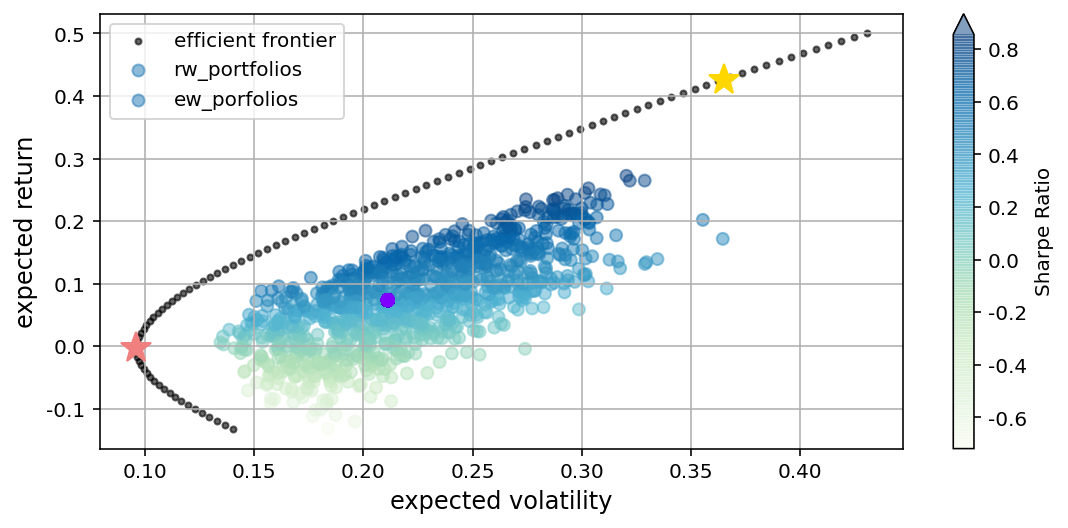

In [52]:
plt.figure(figsize=(9,4))
cmap_lst = [plt.cm.rainbow, plt.cm.Blues, plt.cm.autumn, plt.cm.GnBu, plt.cm.Pastel2, plt.cm.Accent,]

# 1000개 임의의 비율로 구성된 Portfolios + (c= rrets/vols) 추가하면 비율이나옴
rw_porfolios = plt.scatter(rvols, rrets, c= rrets/rvols, cmap=cmap_lst[3], marker='o',alpha=0.5)  
plt.colorbar(label = 'Sharpe Ratio',extend='max') # colorbar 화살표 방향
ew_porfolios = plt.scatter(ewvols, ewrets, c = ewvols/ewrets, cmap=cmap_lst[0], marker='o', alpha=0.5 )
# 동일한 수익률에서 분산이 최소인 Portfolios
efficient_frontier = plt.scatter(tvols_mv, trets, c='black',marker='.',alpha=0.6) 

# 최대 Sharpe를 빨간 별로 표시 / 최소 분산을 보라색 별로 표시
# optimal weights 넣은 statistics 함수의 return값 중 기대수익률과 표준편차
plt.plot(statistics(opt_sr['x'])[1], statistics(opt_sr['x'])[0], marker='*', c='gold', markersize=16.0)
plt.plot(statistics(opt_v['x'])[1], statistics(opt_v['x'])[0], marker='*', c='lightcoral', markersize=16.0) 

plt.legend((efficient_frontier, rw_porfolios, ew_porfolios), ('efficient frontier', 'rw_portfolios','ew_porfolios'), loc='upper left', shadow=False)
plt.grid(True)
plt.xlabel('expected volatility',size=12)
plt.ylabel('expected return',size=12)

plt.show()

In [32]:
print('① Portpolio with Max Sharpe-ratio  \n - expected return: {} \n - expected volatility :{}'.format(statistics(opt_sr['x'])[0], statistics(opt_sr['x'])[1],))
all_inv_sr = pd.DataFrame(tweights_sr[0],index=ticker, columns=['투자비율']).round(2).T
all_inv_sr

print('\n② Portpolio with Min Variance   \n - expected return: {} \n - expected volatility :{} \n - allocation of investment : \n '.format(statistics(opt_v['x'])[0], statistics(opt_v['x'])[1]))
all_inv_mv = pd.DataFrame(tweights_mv[0],index=ticker, columns=['투자비율']).round(2).T
all_inv_mv

① Portpolio with Max Sharpe-ratio  
 - expected return: 0.42628769258430954 
 - expected volatility :0.36508322744530947


,삼성전자,현대차,POSCO,현대모비스,SK하이닉스,NAVER,한국전력,삼성전자우,신한지주,기아차,서흥캅셀,한국단자,STX중공업,대원강업,태영건설,한화손해보험,JB금융지주,부광약품,부산가스,크라운제과
투자비율,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37,0.0,0.0,0.0,0.0,0.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0



② Portpolio with Min Variance   
 - expected return: -0.003263787522628084 
 - expected volatility :0.09580325938203989 
 - allocation of investment : 
 


,삼성전자,현대차,POSCO,현대모비스,SK하이닉스,NAVER,한국전력,삼성전자우,신한지주,기아차,서흥캅셀,한국단자,STX중공업,대원강업,태영건설,한화손해보험,JB금융지주,부광약품,부산가스,크라운제과
투자비율,0.0,0.04,0.0,0.0,0.0,0.0,0.11,0.0,0.03,0.1,0.01,0.13,0.08,0.02,0.0,0.12,0.0,0.0,0.35,0.02
